# SECTION 07, K-means

Building energy centers for China's provincial capitals

In [27]:
from pylab import mpl
import re
import math
import matplotlib.pyplot as plt
plt.style.use('default')
import networkx as nx
import random
from collections import defaultdict
import numpy as np

In [28]:
mpl.rcParams['font.sans-serif'] = ['SimHei']  # Default font
mpl.rcParams['axes.unicode_minus'] = False  # Fix issue with negative signs appearing as blocks

In [29]:
coordination_source = """
{name:'Lanzhou', geoCoord:[103.73, 36.03]},
{name:'Jiayuguan', geoCoord:[98.17, 39.47]},
{name:'Xining', geoCoord:[101.74, 36.56]},
{name:'Chengdu', geoCoord:[104.06, 30.67]},
{name:'Shijiazhuang', geoCoord:[114.48, 38.03]},
{name:'Lhasa', geoCoord:[102.73, 25.04]},
{name:'Guiyang', geoCoord:[106.71, 26.57]},
{name:'Wuhan', geoCoord:[114.31, 30.52]},
{name:'Zhengzhou', geoCoord:[113.65, 34.76]},
{name:'Jinan', geoCoord:[117, 36.65]},
{name:'Nanjing', geoCoord:[118.78, 32.04]},
{name:'Hefei', geoCoord:[117.27, 31.86]},
{name:'Hangzhou', geoCoord:[120.19, 30.26]},
{name:'Nanchang', geoCoord:[115.89, 28.68]},
{name:'Fuzhou', geoCoord:[119.3, 26.08]},
{name:'Guangzhou', geoCoord:[113.23, 23.16]},
{name:'Changsha', geoCoord:[113, 28.21]},
{name:'Haikou', geoCoord:[110.35, 20.02]},
{name:'Shenyang', geoCoord:[123.38, 41.8]},
{name:'Changchun', geoCoord:[125.35, 43.88]},
{name:'Harbin', geoCoord:[126.63, 45.75]},
{name:'Taiyuan', geoCoord:[112.53, 37.87]},
{name:'Xi'an', geoCoord:[108.95, 34.27]},
{name:'Taiwan', geoCoord:[121.30, 25.03]},
{name:'Beijing', geoCoord:[116.46, 39.92]},
{name:'Shanghai', geoCoord:[121.48, 31.22]},
{name:'Chongqing', geoCoord:[106.54, 29.59]},
{name:'Tianjin', geoCoord:[117.2, 39.13]},
{name:'Hohhot', geoCoord:[111.65, 40.82]},
{name:'Nanning', geoCoord:[108.33, 22.84]},
{name:'Tibet', geoCoord:[91.11, 29.97]},
{name:'Yinchuan', geoCoord:[106.27, 38.47]},
{name:'Urumqi', geoCoord:[87.68, 43.77]},
{name:'Hong Kong', geoCoord:[114.17, 22.28]},
{name:'Macau', geoCoord:[113.54, 22.19]}
"""

In [30]:
city_location = {
    'Hong Kong': (114.17, 22.28)
}

In [31]:
test_string = "{name:'LanZhou', geoCoord:[103.73, 36.03]},"
pattern = re.compile(r"name:'(\w+)',\s+geoCoord:\[(\d+.\d+),\s(\d+.\d+)\]")

In [32]:
for line in coordination_source.split('\n'):
    city_info = pattern.findall(line)
    if not city_info: continue
    
    # following: we find the city info
    
    city, long, lat = city_info[0]
    
    long, lat = float(long), float(lat)
    
    city_location[city] = (long, lat)

In [33]:
city_location

{'Hong Kong': (114.17, 22.28),
 'Lanzhou': (103.73, 36.03),
 'Jiayuguan': (98.17, 39.47),
 'Xining': (101.74, 36.56),
 'Chengdu': (104.06, 30.67),
 'Shijiazhuang': (114.48, 38.03),
 'Lhasa': (102.73, 25.04),
 'Guiyang': (106.71, 26.57),
 'Wuhan': (114.31, 30.52),
 'Zhengzhou': (113.65, 34.76),
 'Jinan': (117.0, 36.65),
 'Nanjing': (118.78, 32.04),
 'Hefei': (117.27, 31.86),
 'Hangzhou': (120.19, 30.26),
 'Nanchang': (115.89, 28.68),
 'Fuzhou': (119.3, 26.08),
 'Guangzhou': (113.23, 23.16),
 'Changsha': (113.0, 28.21),
 'Haikou': (110.35, 20.02),
 'Shenyang': (123.38, 41.8),
 'Changchun': (125.35, 43.88),
 'Harbin': (126.63, 45.75),
 'Taiyuan': (112.53, 37.87),
 'Taiwan': (121.3, 25.03),
 'Beijing': (116.46, 39.92),
 'Shanghai': (121.48, 31.22),
 'Chongqing': (106.54, 29.59),
 'Tianjin': (117.2, 39.13),
 'Hohhot': (111.65, 40.82),
 'Nanning': (108.33, 22.84),
 'Tibet': (91.11, 29.97),
 'Yinchuan': (106.27, 38.47),
 'Urumqi': (87.68, 43.77),
 'Macau': (113.54, 22.19)}

In [35]:
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

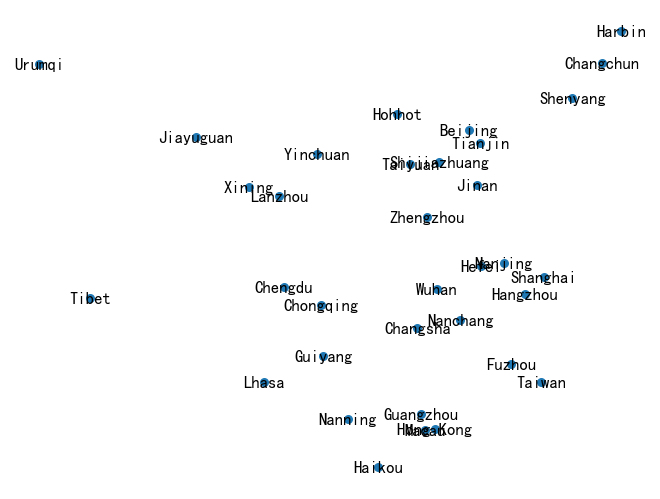

In [36]:
%matplotlib inline

city_graph = nx.Graph()
city_graph.add_nodes_from(list(city_location.keys()))
nx.draw(city_graph, city_location, with_labels=True, node_size=30)

## K-means: Initial k random centers

In [145]:
k = 10

all_x = []
all_y = []

for _, location in city_location.items():
    x, y = location
    all_x.append(x)
    all_y.append(y)

In [174]:
def get_random_center(all_x, all_y):
    r_x = random.uniform(min(all_x), max(all_x))
    r_y = random.uniform(min(all_y), max(all_y))
    
    return r_x, r_y

get_random_center(all_x, all_y)

K = 5
centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}

In [175]:
closet_points = defaultdict(list)

for x, y, in zip(all_x, all_y):
    closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])    
    
    closet_points[closet_c].append([x, y])

In [176]:
def iterate_once(centers, closet_points, threshold=5):
    have_changed = False
    
    for c in closet_points:
        former_center = centers[c]

        neighbors = closet_points[c]

        neighbors_center = np.mean(neighbors, axis=0)

        if geo_distance(neighbors_center, former_center) > threshold:
            centers[c] = neighbors_center
            have_changed = True
        else:
            pass ## keep former center
        
    return centers, have_changed

In [177]:
def kmeans(Xs, k, threshold=5):
    all_x = Xs[:, 0]
    all_y = Xs[:, 1]
    
    K = k
    
    centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}
    
    changed = True
    
    while changed:
        closet_points = defaultdict(list)

        for x, y, in zip(all_x, all_y):
            closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])    
            closet_points[closet_c].append([x, y])   
            
        centers, changed = iterate_once(centers, closet_points, threshold)
        print('iteration')

    return centers

In [178]:
kmeans(np.array(list(city_location.values())), k=5, threshold=5)

iteration
iteration
iteration
iteration


{'1': array([114.31714286,  23.08571429]),
 '2': array([91.11, 29.97]),
 '3': array([112.88416667,  29.95166667]),
 '4': array([118.29777778,  40.42777778]),
 '5': array([99.518, 38.86 ])}

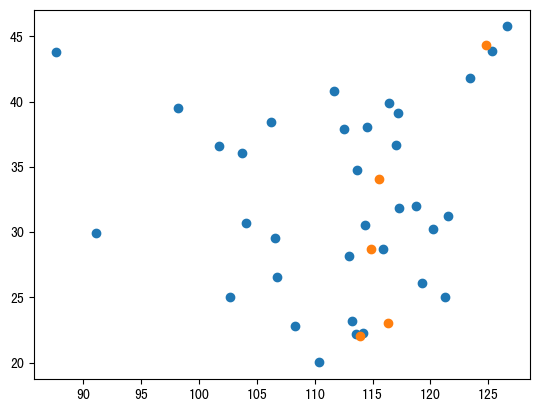

In [179]:
plt.scatter(all_x, all_y)
plt.scatter(*zip(*centers.values()))

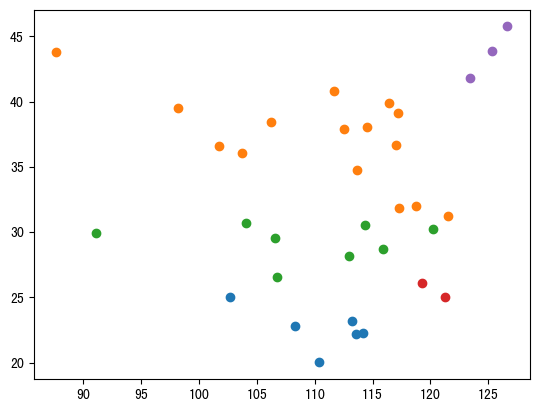

In [180]:
for c, points in closet_points.items():
    plt.scatter(*zip(*points))

In [181]:
city_location_with_station = {
    'Energy station-{}'.format(i): position for i, position in centers.items()
}
city_location_with_station


{'Energy station-1': (113.92487577278227, 22.04691289422985),
 'Energy station-2': (114.86815028122322, 28.721989454656374),
 'Energy station-3': (116.34103075543152, 23.045791031569824),
 'Energy station-4': (124.83913158367048, 44.35036826994592),
 'Energy station-5': (115.52678091748098, 34.06714120433021)}

In [182]:
def draw_cities(citise, color=None):
    city_graph = nx.Graph()
    city_graph.add_nodes_from(list(citise.keys()))
    nx.draw(city_graph, citise, node_color=color, with_labels=True, node_size=30)

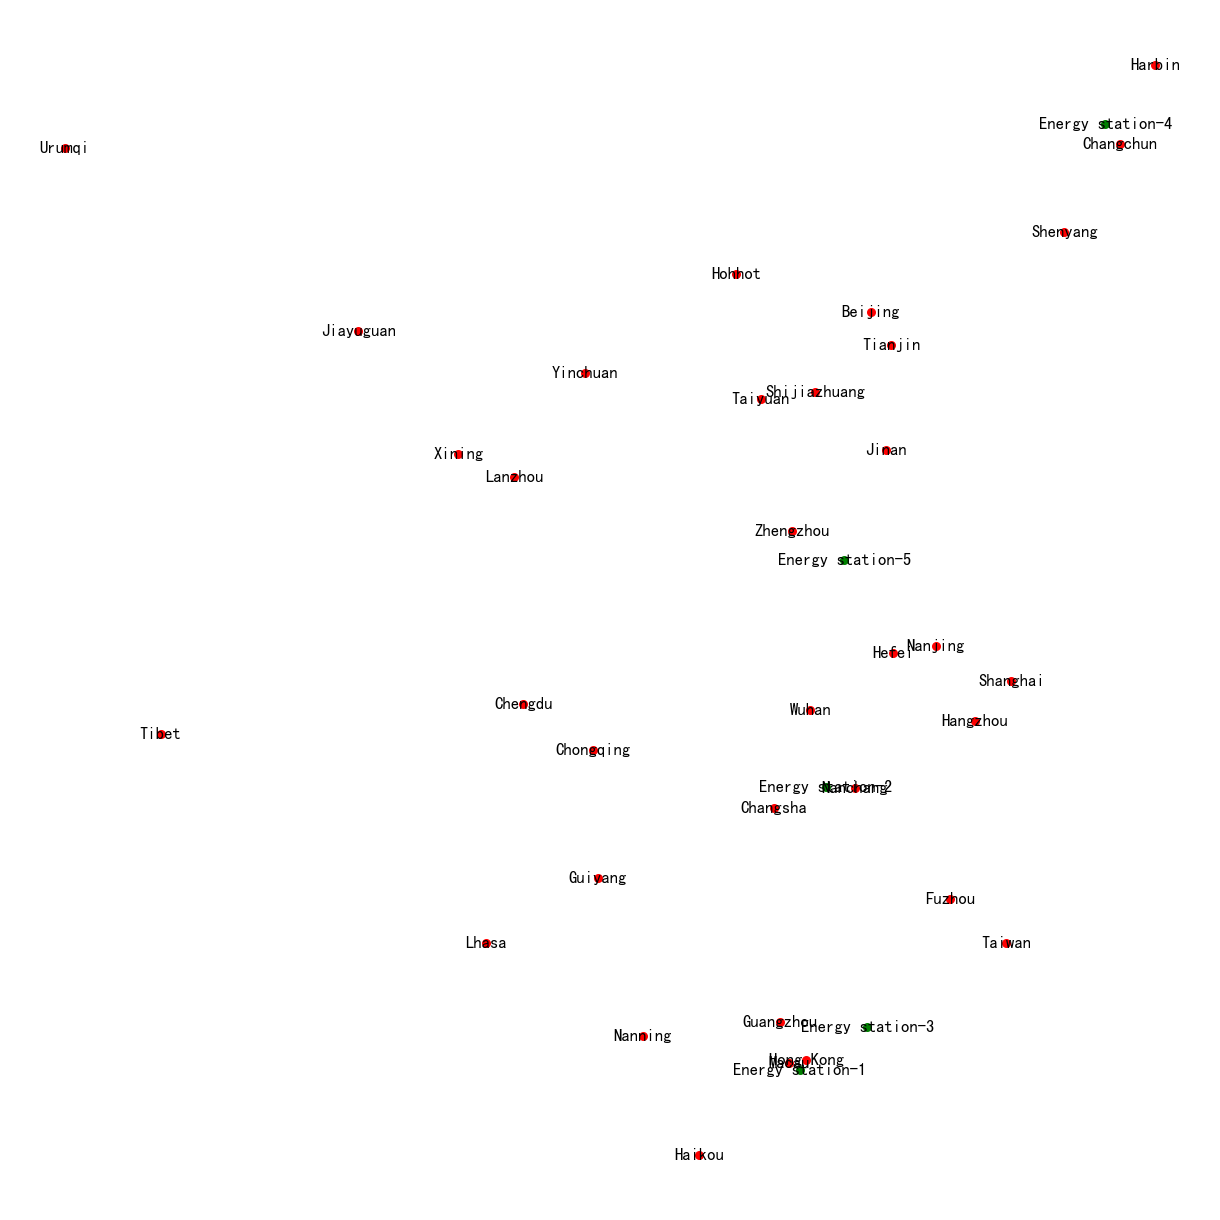

In [183]:
%matplotlib inline

plt.figure(1,figsize=(12,12)) 
draw_cities(city_location_with_station, color='green')
draw_cities(city_location, color='red')